# **3 Métodos de Paralelización en Spark**

Vamos a aprender tres maneras de explotar la paralelizacion presente en un codigo usando Spark. Esta parte del curso fue escrita usando partes de un [articulo de TDS](https://towardsdatascience.com/3-methods-for-parallelization-in-spark-6a1a4333b473)

Siempre que estés utilizando marcos de datos Spark y bibliotecas que operan sobre estas estructuras de datos, puedes escalar a conjuntos de datos masivos que se distribuyen a través de un clúster. Sin embargo, hay algunos escenarios donde las bibliotecas pueden no estar disponibles para trabajar con marcos de datos Spark, y se necesitan otros enfoques para lograr la paralelización con Spark. Esta publicación discute tres formas diferentes de lograr la paralelización en PySpark:

1. **Spark Nativo:** si estás utilizando marcos de datos Spark y bibliotecas (por ejemplo, MLlib), entonces tu código será paralelizado y distribuido nativamente por Spark.
2. **Pools de Hilos:** La [biblioteca multiprocessing](https://docs.python.org/3/library/multiprocessing.html) puede ser utilizada para ejecutar hilos concurrentes de Python, e incluso realizar operaciones con marcos de datos Spark.
3. **Pandas UDFs:** Una nueva característica en Spark que permite el procesamiento paralelizado en marcos de datos Pandas dentro de un entorno Spark.

Proporcionaré ejemplos de cada uno de estos diferentes enfoques para lograr el paralelismo en PySpark, utilizando el conjunto de datos de [diabetes](https://www.geeksforgeeks.org/sklearn-diabetes-dataset/) (el ejemplo original usa el dataset de housing de Boston, pero este fue quitado de Sklearn) como un conjunto de datos de muestra. El notebook con el codigo esta disponible en el repositorio con el numero de esta clase.

Antes de comenzar, es importante hacer una distinción entre paralelismo y distribución en Spark. 

## Paralelismo vs distribucion en Spark

Cuando una tarea se paraleliza en Spark, significa que las tareas concurrentes pueden estar ejecutándose en el **nodo driver** o en los **nodos workers**. Cómo es que se divide la tarea entre estos diferentes nodos en el clúster depende de los tipos de estructuras de datos y bibliotecas que estés utilizando. Es posible tener paralelismo sin distribución en Spark, lo que significa que el nodo de controlador puede estar realizando todo el trabajo. Esta es una situación que ocurre con el ejemplo de scikit-learn con pools de hilos que se plantea mas abajo, y **debe evitarse si es posible**. Cuando una tarea se distribuye en Spark, significa que los datos sobre los que se está operando se dividen entre diferentes nodos en el clúster, y que las tareas se están realizando concurrentemente. Idealmente, deseas crear tareas que sean tanto paralelizadas como distribuidas.

## Nodo unico

Antes de mostrar como es el procesamiento paralelo en Spark, empecemos con un ejemplo con un unico nodo en Python basico. Vamos a usar el dataset de diabetes disponible en Sklearn . Con este dataset podemos construir un predictor con 10 features. El codigo debajo muestra como descargar el dataset y convertirlo a un dataframe de Pandas.

Importamos el dataset de load_diabetes y creamos un dataframe en Pandas

In [38]:
import numpy as np
import pandas as pd

# load the diab data set|
from sklearn.datasets import load_diabetes
diab = load_diabetes()

# convert to a Pandas Data Frame
diab_pd = pd.DataFrame(data= np.c_[diab['data'],diab['target']], 
                         columns= np.append(diab['feature_names'], 'target')).sample(frac=1)
print(diab_pd.shape)
diab_pd.head(5)


(442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
360,0.016281,-0.044642,0.020739,0.021872,-0.013953,-0.013214,-0.006584,-0.002592,0.013317,0.040343,281.0
320,-0.023677,-0.044642,0.030440,-0.005670,0.082364,0.092004,-0.017629,0.071210,0.033043,0.003064,122.0
428,0.048974,0.050680,0.088642,0.087287,0.035582,0.021546,-0.024993,0.034309,0.066051,0.131470,310.0
222,-0.023677,0.050680,-0.025607,0.042529,-0.053855,-0.047660,-0.021311,-0.039493,0.001148,0.019633,252.0
161,-0.045472,0.050680,0.063852,0.070072,0.133274,0.131461,-0.039719,0.108111,0.075741,0.085907,217.0


A continuación, dividimos el conjunto de datos en grupos de entrenamiento y prueba y separamos las características de las etiquetas para cada grupo. Luego usamos la clase LinearRegression para ajustar el conjunto de datos de entrenamiento y crear predicciones para el conjunto de datos de prueba. La última parte del codigo a continuación muestra cómo calcular el coeficiente de correlación entre los precios de las casas reales y los predichos.

Separamos en conjunto de entrenamiento y de prueba

In [39]:
# separamos la etiqueta a predecir de las features. 
y = diab_pd['target']
X = diab_pd.drop(['target'], axis=1)

# Creamos el dataset de entrenamiento (~80%) y el de prueba
X_train = X[:400]
X_test = X[400:]
y_train = y[:400]
y_test = y[400:]


Aplicamos un modelo de regresion lineal sobre el dataset. Calculamos el error usando el metodo R-Squared (pearsonr) y MAE (Mean Absolute Error)


In [40]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# train a classifier 
lr = LinearRegression()
model = lr.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# error metrics
r = pearsonr(y_pred, y_test)
mae = sum(abs(y_pred - y_test))/len(y_test)
print("R-squared: " + str(r[0]**2))
print("MAE: " + str(mae))


R-squared: 0.5877335643714796
MAE: 37.45895893365766


Ahora tenemos una tarea que nos gustaría paralelizar. Para este tutorial, el objetivo de paralelizar la tarea es probar diferentes hiperparámetros simultáneamente, pero este es solo un ejemplo de las posibles tareas paralelizables con Spark.

## **Spark Nativo**

Si utilizas DataFrames y bibliotecas de Spark, entonces Spark paralelizará y distribuirá tu tarea de manera nativa. Primero, necesitaremos convertir el Dataframe de Pandas a un DataFrame de Spark, y luego transformar las features en una matriz esparsa, requerida por MLlib. El codigo a continuación muestra cómo realizar esta tarea para el conjunto de datos de diabetes.

In [52]:
# inicializamos una sesion de Spark

from pyspark.sql import SparkSession
# local[N cantidad de cores]
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("3-maneras-de-paralelizar") \
    .getOrCreate()

In [53]:

# Creamos un DataFrame de Spark a partir de diab_pd
diab_sp=spark.createDataFrame(diab_pd) 
diab_sp.printSchema()
diab_sp.show()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- s1: double (nullable = true)
 |-- s2: double (nullable = true)
 |-- s3: double (nullable = true)
 |-- s4: double (nullable = true)
 |-- s5: double (nullable = true)
 |-- s6: double (nullable = true)
 |-- target: double (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|                 age|                 sex|                 bmi|                  bp|                  s1|                  s2|                  s3|                  s4|                  s5|                  s6|target|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------

En general, es mejor evitar cargar datos en una representación de Pandas antes de convertirlos a Spark. En su lugar, utiliza interfaces como *spark.read* para cargar fuentes de datos directamente en marcos de datos de Spark.

Ahora que tenemos los datos preparados en el formato Spark, podemos usar MLlib para realizar el ajuste y la predicción del modelo de forma paralelizada. El codigo a continuación muestra cómo instanciar y entrenar un modelo de regresión lineal y calcular el coeficiente de correlación para el target, que en este caso representa la progresion estimada de la enfermedad.

Separacion de dataset en entrenamiento y prueba

In [55]:
diab_train = spark.createDataFrame(diab_pd[:400])
diab_test = spark.createDataFrame(diab_pd[400:])


Se usa VectorAssembler para convertir los datasets de entrenamiento y prueba a una representacion en vectores. MLlib requiere que el input sea en formato vector. El proposito de VectorAssembler es combinar multiples columnas a una sola columna con vectores con cada valor. 

In [56]:
from pyspark.ml.feature import VectorAssembler

# Instanciacion de un objeto VectorAssembler. inputCols toma todas las columnas del dataset con excepcion de 'target' 
# y asignamos como 'features' al nombre de la columna que va a contener los vectores
assembler = VectorAssembler(inputCols= diab_train.schema.names[:(diab_pd.shape[1] - 1)],  outputCol="features" )

# usamos el metodo transform para crear las columnas con vectores en el dataset de entrenamiento y de prueba.
# Se seleccionan las columnas features, que son los feature vectorizados, y target. 
diab_train = assembler.transform(diab_train).select('features', 'target') 
diab_test = assembler.transform(diab_test).select('features', 'target') 

# las 5 primeras filas del dataset de entrenamiento convertido a array de vectores. 
display(diab_train.take(5))

[Row(features=DenseVector([0.0163, -0.0446, 0.0207, 0.0219, -0.014, -0.0132, -0.0066, -0.0026, 0.0133, 0.0403]), target=281.0),
 Row(features=DenseVector([-0.0237, -0.0446, 0.0304, -0.0057, 0.0824, 0.092, -0.0176, 0.0712, 0.033, 0.0031]), target=122.0),
 Row(features=DenseVector([0.049, 0.0507, 0.0886, 0.0873, 0.0356, 0.0215, -0.025, 0.0343, 0.0661, 0.1315]), target=310.0),
 Row(features=DenseVector([-0.0237, 0.0507, -0.0256, 0.0425, -0.0539, -0.0477, -0.0213, -0.0395, 0.0011, 0.0196]), target=252.0),
 Row(features=DenseVector([-0.0455, 0.0507, 0.0639, 0.0701, 0.1333, 0.1315, -0.0397, 0.1081, 0.0757, 0.0859]), target=217.0)]

Hacemos una regresion lineal y calculamos el error

In [57]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.1, elasticNetParam=0.5, labelCol="target")

# Fit & Transform
model = lr.fit(diab_train)
diab_pred = model.transform(diab_test)

# Resultados
r = diab_pred.stat.corr("prediction", "target")
print("R-squared: " + str(r**2))


R-squared: 0.5820091739314875


Vamos a observar en la UI el progreso de los jobs de spark. Vemos que se reparten en 4 nodos trabajadores, uno por cada core

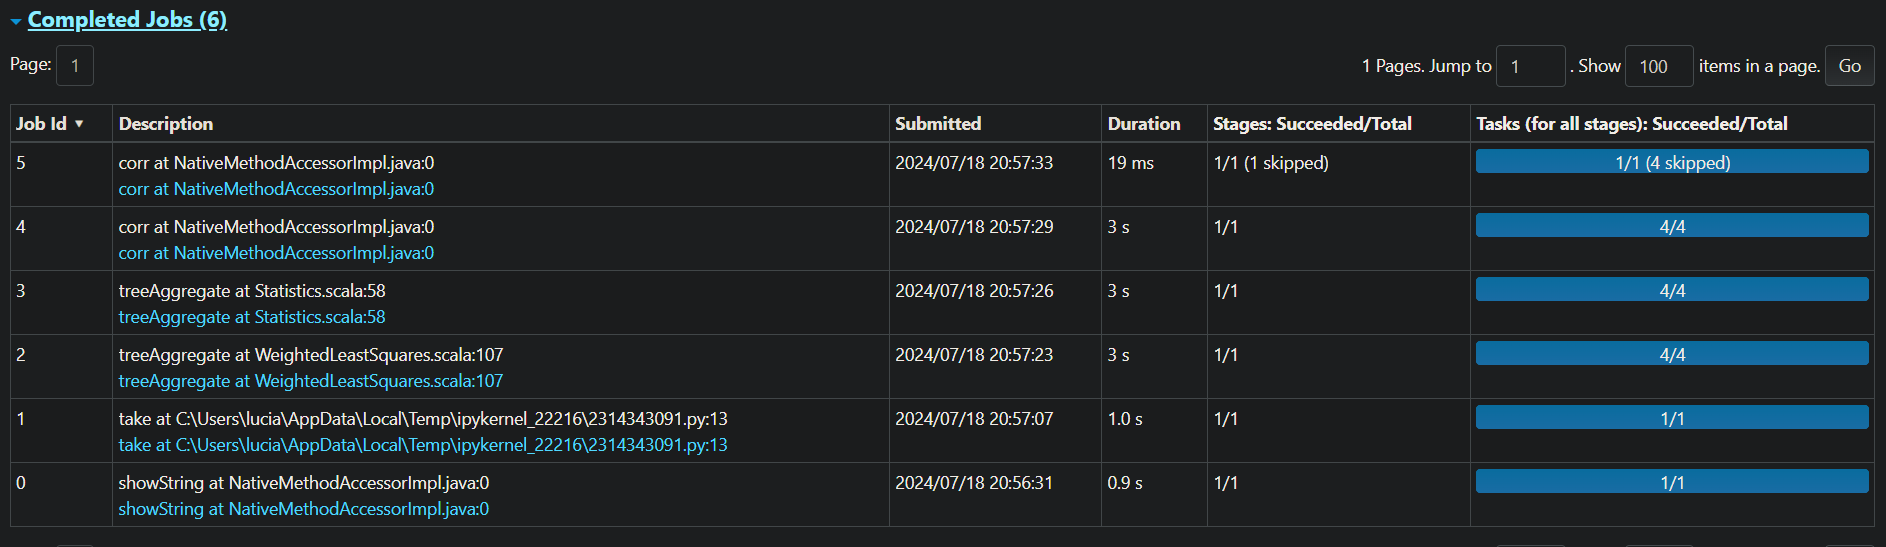

Ahora tenemos una tarea de fit y predicción del modelo que está paralelizada. Sin embargo, ¿qué pasa si también queremos probar simultáneamente diferentes configuraciones de hiperparámetros? Puedes hacer esto manualmente, como se muestra en las siguientes dos secciones, o usar la clase *CrossValidator* que realiza esta operación de manera nativa en Spark. El código a continuación muestra cómo probar diferentes parámetros de red elástica usando validación cruzada para seleccionar el modelo de mejor rendimiento.

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=LinearRegression(labelCol = "target"),  
                           estimatorParamMaps=ParamGridBuilder().addGrid(LinearRegression.elasticNetParam, [0, 0.5, 1.0]).build(),
                           evaluator=RegressionEvaluator(labelCol = "target", metricName = "r2"),
                           numFolds=10)

# aplicamos cross validation para quedarnos con el mejor resultado del fit
cvModel = crossval.fit(diab_train) 
model = cvModel.bestModel

# calculate results 
diab_pred = model.transform(diab_test)
r = diab_pred.stat.corr("prediction", "target")
print("R-squared: " + str(r**2))


R-squared: 0.4847035636761517


Si en tu desarrollo resulta que MLlib tiene las bibliotecas que necesitas para construir modelos predictivos, entonces generalmente es sencillo paralelizar una tarea. Sin embargo, puede que quieras usar algoritmos que no están incluidos en MLlib, o usar otras bibliotecas de Python que no funcionan directamente con marcos de datos de Spark. Aquí es donde los thread pools y las UDF de Pandas se vuelven útiles.

## **Thread Pools**

Una de las formas en que puedes lograr el paralelismo en PySpark sin usar DataFrames  de Spark es usando el módulo multiprocessing de Python. Esta librería proporciona una abstracción de hilo que puedes usar para crear hilos de ejecución concurrentes. Sin embargo, por defecto, todo tu código se ejecutará en el nodo controlador. Esto quiere decir que el programa entero se divide en hilos, pero se corren todos en un solo nodo. Se estarían desaprovechando recursos. 

El fragmento a continuación muestra cómo crear un conjunto de hilos que se ejecutarán en paralelo, devolviendo resultados para diferentes hiperparámetros para un bosque aleatorio. 

In [58]:
# sklearn version 
from sklearn.ensemble import RandomForestRegressor as RFR
from multiprocessing.pool import ThreadPool

# allow up to 5 concurrent threads
pool = ThreadPool(5)

# hyperparameters to test out (n_trees)
parameters = [ 10, 20, 50]

# define a function to train a RF model and return metrics 
def sklearn_random_forest(trees, X_train, X_test, y_train, y_test):

    # train a random forest regressor with the specified number of trees
    rf= RFR(n_estimators = trees)
    model = rf.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)
    r = pearsonr(y_pred, y_test)

    # return the number of trees, and the R value 
    return [trees, r[0]**2]  

# run the tasks 
pool.map(lambda trees: sklearn_random_forest(trees, X_train, X_test, y_train, y_test), parameters)

  

[[10, 0.3777135487671219], [20, 0.3594625662240637], [50, 0.4378130615173498]]

Recordar en este punto, que `X_train`, `X_test`, `y_train` y  `y_test` son variables creadas a partir de un Dataframe de pandas, y la libreria que se uso en el codigo mas arriba no es particular de Spark o PySpark, por lo que podrian correr este codigo en una maquina sin Spark necesariamente. A lo que se refiere cuando dice 'todo corre en el nodo controlador' es que la maquina que dispararia la ejecucion simultanea en muchos nodos (que pueden ser muchas maquinas) estaria, con este codigo, usando solo la maquina controladora para ejecutarlos, desperdiciando recursos.

Este enfoque funciona utilizando la función map en un Thread Pool. La función map toma una expresión lambda y un array de valores como entrada, e invoca la expresión lambda para cada uno de los valores en el array. Una vez que todos los hilos completan, la salida muestra el valor del hiperparámetro (*n_estimators*) y el resultado de R-squared para cada hilo.

Usar grupos de hilos de esta manera es peligroso, porque todos los hilos se ejecutarán en el nodo driver. Si es posible, es mejor usar Dataframes de Spark cuando se trabaja con Thread Pools, porque entonces las operaciones se distribuirán a través de los nodos workers en el clúster. La versión de MLib que usa Thread Pools se muestra en el ejemplo a continuación, que distribuye las tareas a nodos workers.

In [59]:
# spark version
from pyspark.ml.regression import RandomForestRegressor

# define a function to train a RF model and return metrics 
def mllib_random_forest(trees, diab_train, diab_test):

    # train a random forest regressor with the specified number of trees
    rf = RandomForestRegressor(numTrees = trees, labelCol="target")
    model = rf.fit(diab_train)

    # make predictions
    diab_pred = model.transform(diab_test)
    r = diab_pred.stat.corr("prediction", "target")

    # return the number of trees, and the R value 
    return [trees, r**2]
  
# run the tasks 
pool.map(lambda trees: mllib_random_forest(trees, diab_train, diab_test), parameters)
  

[[10, 0.4891275294363514],
 [20, 0.49575991148048665],
 [50, 0.46010134846149314]]

## **Pandas UDFs**

Una de las características más nuevas en Spark que permite el procesamiento paralelo son las Pandas UDFs. Con esta característica, puedes dividir un DataFrame de Spark en conjuntos de datos más pequeños que se distribuyen y convierten en objetos de Pandas, donde se puede aplicar cualquier función, y luego los resultados se combinan nuevamente en un solo DataFrame de Spark. Esencialmente, las UDF permiten a los científicos de datos trabajar con bibliotecas base de Python mientras obtienen los beneficios de la paralelización y distribución. (Una introduccion mas completa a PySpark con mencion a estos UDF existe en [este articulo](https://towardsdatascience.com/a-brief-introduction-to-pyspark-ff4284701873))

El código a continuación muestra cómo realizar el ajuste de hiperparámetros de forma paralelizada (y distribuida) cuando se usa scikit-learn. La primera parte de este script toma el conjunto de datos de diabetes y realiza un `cross join` que no es mas que un join tradicional pero sin la clausula `ON` que normalmente sirve para unir tablas por ID. En este contexto nos sirve para crear múltiples copias del conjunto de datos de entrada, y también agrega un valor de árbol (*n_estimators*) a cada grupo. Luego, definimos una UDF de Pandas que toma una partición como entrada (una de estas copias), y como resultado devuelve un marco de datos de Pandas que especifica el valor del hiperparámetro que se probó y el resultado (*R-squared*). El paso final es la llamada groupby y apply que realiza el cálculo paralelizado.

In [60]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

# setup the spark data frame as a table
diab_sp.createOrReplaceTempView("diab")

# add train/test label and expand the data set by 3x (each num trees parameter)
full_df = spark.sql("""
  select *
  from (
    select *, case when rand() < 0.8 then 1 else 0 end as training 
    from diab
  ) b
  cross join (
      select 11 as trees union all select 20 as trees union all select 50 as trees)
""")

schema = StructType([StructField('trees', LongType(), True),
                     StructField('r_squared', DoubleType(), True)])  

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def train_RF(diab_pd):
    trees = diab_pd['trees'].unique()[0]

    # get the train and test groups 
    diab_train = diab_pd[diab_pd['training'] == 1]
    diab_test = diab_pd[diab_pd['training'] == 0] 
        
    # create data and label groups 
    y_train = diab_train['target']
    X_train = diab_train.drop(['target'], axis=1)
    y_test = diab_test['target']
    X_test = diab_test.drop(['target'], axis=1)
   
    # train a classifier 
    rf= RFR(n_estimators = trees)
    model = rf.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)
    r = pearsonr(y_pred, y_test)
    
    # return the number of trees, and the R value 
    return pd.DataFrame({'trees': trees, 'r_squared': (r[0]**2)}, index=[0])
  
# use the Pandas UDF
results = full_df.groupby('trees').apply(train_RF) # el group by separa por 'tree', y el apply entrena cada grupo

# print the results 
print(results.take(3))


D:\apps\spark-3.5.0-bin-hadoop3\python\pyspark\sql\pandas\group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


[Row(trees=11, r_squared=0.4812732531822924), Row(trees=20, r_squared=0.5734258461076146), Row(trees=50, r_squared=0.560479043000222)]


Analicemos lo que nos permitio hacer este ejemplo. Nos permitio paralelizar una validacion de una variedad de hiperparametros en distintas configuraciones en paralelo, usando dataframes de pandas en lugar de Spark, a traves de UDF. Especificandole una funcion con un decorator particular, se puede correr una tarea en spark de manera paralela como si fuera Pandas. 


## **Conclusión**

Hay múltiples formas de lograr el paralelismo cuando se usa PySpark para la ciencia de datos. Es mejor usar bibliotecas nativas si es posible, pero según tus casos de uso puede que no haya bibliotecas de Spark disponibles. En esta situación, es posible usar Thread Pools o UDFs de Pandas para paralelizar tu código Python en un entorno Spark. Solo ten cuidado con cómo paralelizas tus tareas y cuida siempre de distribuir las cargas de trabajo en los nodos workers.

In [37]:
spark.stop()